In [ ]:
import numpy as np
import torch
import cv2
import os
from utils import *
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

In [ ]:
## load the data
path = os.getcwd() + '/../data/'  
images_np = images_np_load(path, plot=False)

In [ ]:
def get_padded_image(image, pad):
    """给图像周围补零，方便边界处理"""
    if image.ndim == 3:
        return np.pad(image, ((pad,pad),(pad,pad),(0,0)), mode='constant')
    else:
        return np.pad(image, ((pad,pad),(pad,pad)), mode='constant')


def log_polar_offsets(regionsize, num_r=4, num_theta=20):
    """生成 log-polar 相对坐标偏移表"""
    r = np.logspace(0, np.log10(regionsize / 2), num_r) - 1
    #r = np.linsapce(0, r_max, num_r)
    theta = np.linspace(0, 2*np.pi, num_theta, endpoint=False)
    
    rr, tt = np.meshgrid(r, theta, indexing='ij')
    dy = (rr * np.sin(tt)).astype(int)
    dx = (rr * np.cos(tt)).astype(int)
    offsets = np.stack([dy, dx], axis=-1)  # shape (num_r,num_theta,2)

    return offsets


def self_similarity_logpolar_fast(image, regionsize=81, patchsize=5, alpha=0.1, num_r=4, num_theta=20):
    H, W = image.shape[:2]
    out_H, out_W = H - regionsize + 1, W - regionsize + 1
    pad = regionsize // 2 + patchsize // 2

    padded = get_padded_image(image, pad)
    offsets = log_polar_offsets(regionsize, num_r, num_theta)
    sim_map = np.zeros((out_H, out_W, num_r, num_theta), dtype=np.float32)

    # 枚举所有中心点
    y_coords, x_coords = np.arange(out_H) + pad, np.arange(out_W) + pad

    for i, y in enumerate(y_coords):
        for j, x in enumerate(x_coords):
            # 中心 patch
            yc, xc = y, x
            cp = padded[yc - patchsize//2 : yc + patchsize//2 + 1,
                        xc - patchsize//2 : xc + patchsize//2 + 1]
            # log-polar 索引
            ys = yc + offsets[:,:,0]
            xs = xc + offsets[:,:,1]


            for r_idx in range(num_r):
                for t_idx in range(num_theta):
                    y_patch = ys[r_idx, t_idx]
                    x_patch = xs[r_idx, t_idx]
                    patch = padded[y_patch : y_patch+patchsize,
                                   x_patch : x_patch+patchsize]
                    sim_map[i,j,r_idx,t_idx] = np.exp(-alpha * np.sum((cp - patch)**2))
    return sim_map


# 示例调用
image = np.transpose(images_np[0], [1,2,0])
sim_map_fast = self_similarity_logpolar_fast(image)
print(sim_map_fast.shape)  # (H', W', num_r, num_theta)


In [ ]:
def visualize_logpolar_feature(sim_feature):
    """
    sim_feature: shape (num_r, num_theta)
    """
    num_r, num_theta = sim_feature.shape
    
    # 扩展半径数组和角度数组
    r = np.arange(1, num_r+1)  # 可以换成实际 log 半径
    theta = np.linspace(0, 2*np.pi, num_theta, endpoint=False)
    
    # meshgrid，用于极坐标绘图
    Theta, R = np.meshgrid(theta, r)
    
    # 创建极坐标图
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    
    # 绘制扇形图
    c = ax.pcolormesh(Theta, R, sim_feature, shading='auto', cmap='viridis')
    ax.set_theta_zero_location("N")
    ax.set_theta_direction(-1)
    fig.colorbar(c, ax=ax, label='Similarity')
    plt.show()


In [ ]:

visualize_logpolar_feature(sim_map_fast[0][0])


In [ ]:
def visualize_logpolar_feature(sim_feature, r):
    _ , num_theta = sim_feature.shape 
    theta = np.linspace(0, 2*np.pi, num_theta, endpoint=False)
    Theta, R = np.meshgrid(theta, r, indexing='xy')
    # 创建极坐标图
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    # 绘制扇形图
    c = ax.pcolormesh(Theta, R, sim_feature, shading='auto', cmap='gray')
    ax.set_theta_zero_location("E")  
    ax.set_theta_direction(1)        
    fig.colorbar(c, ax=ax, label='Similarity')
    plt.show()

def visualize_similarity_map(similarity_map):
    # 使用imshow显示灰度图像
    plt.imshow(similarity_map, cmap='gray')  # cmap='gray'表示以灰度显示
    plt.colorbar()  # 显示颜色条，帮助了解灰度值的范围
    plt.title("Similarity Map")  # 可选：为图像添加标题
    plt.axis('off')  # 可选：关闭坐标轴显示
    plt.show()

def gaussian_kernel(size: int, sigma: float):
    kernel = torch.zeros((size, size), dtype=torch.float32)
    center = size // 2
    for i in range(size):
        for j in range(size):
            dist = (torch.tensor(i, dtype=torch.float32) - center) ** 2 + (torch.tensor(j, dtype=torch.float32) - center) ** 2
            kernel[i][j] = torch.exp(-dist / (2 * sigma ** 2))
    
    kernel /= kernel.sum()
    return kernel


def log_polar_conversion(similarity_map, num_r=4, num_theta=20):
    R = similarity_map.shape[0] // 2
    r = np.linspace(1, R, num_r + 1)
    theta = np.linspace(-2*np.pi / (num_theta * 2), 2*np.pi - 2*np.pi / (num_theta * 2), num_theta + 1)
    
    return r[1:], theta[1:]

def update_log_polar_map(similarity_map, r, theta, num_r=4, num_theta=20):
    H, W = similarity_map.shape
    log_polar_map = np.zeros((num_r, num_theta)) 
    center_y, center_x = H // 2, W // 2  
    
    for i in range(H):
        for j in range(W):
            
            dy, dx = center_y - i, j - center_x
            r_val, t_val = np.sqrt(dy**2 + dx**2), (np.arctan2(dy, dx) + 2*np.pi) % (2*np.pi)
            if t_val > r[-1]:
                t_val = t_val - 2*np.pi
    
            r_idx, t_idx = np.digitize(r_val, r), np.digitize(t_val, theta) % num_theta  
            if r_idx < num_r:
                log_polar_map[r_idx, t_idx] = max(log_polar_map[r_idx, t_idx], similarity_map[i, j])
    
    return log_polar_map

In [103]:
import numpy as np
from utils import *
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

def get_region(c, size, image):

    if len(image.shape) == 3:
        return image[c[0] - size // 2: c[0] + size // 2, c[1] - size// 2: c[1] + size // 2, :]
    else:
        return image[c[0] - size // 2: c[0] + size // 2, c[1] - size// 2: c[1] + size // 2]


def patch_sim_get(image, x1, x2, patchsize, alpha=0.1):
    region1 = get_region(x1, patchsize, image)
    region2 = get_region(x2, patchsize, image)
    sim = np.exp(-alpha * np.sum((region1 - region2) ** 2))

    return sim

def self_loc_sim_get(image, regionsize=81, patchsize=5):
    H, W = image.shape[0], image.shape[1]
    region_r, patch_r = regionsize // 2, patchsize // 2

    similiarity_map = [[0 for _ in range(0, W - regionsize + 1)] for _ in range(0, H - regionsize + 1)]

    for i in range(0, H - regionsize + 1):
        for j in range(0, W - regionsize + 1):
            print(i, j)
            xc = [i + region_r, j + region_r]
            sim = np.zeros((regionsize - patchsize + 1, regionsize - patchsize + 1)).astype(np.float32)
            
            for m in range(regionsize - patchsize + 1):
                for n in range(regionsize - patchsize + 1):
                    y = [i + m + patch_r, j + n + patch_r]
                    sim[m][n] = patch_sim_get(image, xc, y, patchsize)
            similiarity_map[i][j] = sim

    return np.array(similiarity_map)


def log_polar_offsets(regionsize, num_r=4, num_theta=20):
    """生成 log-polar 相对坐标偏移表"""
    r = np.logspace(0, np.log10(regionsize / 2), num_r) - 1
    theta = np.linspace(0, 2*np.pi, num_theta, endpoint=False)

    rr, tt = np.meshgrid(r, theta, indexing='ij')
    dy = (rr * np.sin(tt)).astype(int)
    dx = (rr * np.cos(tt)).astype(int)
    offsets = np.stack([dy, dx], axis=-1)  

    return offsets


def log_polar_conversion(size, num_r=4, num_theta=20):

    R = size // 2
    r = np.linspace(1, R, num_r + 1)
    theta = np.linspace(-2*np.pi / (num_theta * 2), 2*np.pi - 2*np.pi / (num_theta * 2), num_theta + 1)
    
    return r[1:], theta[1:]


def update_log_polar_map(similarity_map, r, theta, num_r=4, num_theta=20):

    H, W = similarity_map.shape
    log_polar_map = np.zeros((num_r, num_theta)) 
    center_y, center_x = H // 2, W // 2  
    
    for i in range(H):
        for j in range(W):
            dy, dx = center_y - i, j - center_x
            r_val, t_val = np.sqrt(dy**2 + dx**2), (np.arctan2(dy, dx) + 2*np.pi) % (2*np.pi)
            if t_val > r[-1]:
                t_val = t_val - 2*np.pi
    
            r_idx, t_idx = np.digitize(r_val, r), np.digitize(t_val, theta) % num_theta  
            if r_idx < num_r:
                log_polar_map[r_idx, t_idx] = max(log_polar_map[r_idx, t_idx], similarity_map[i, j])
    
    return log_polar_map


def visualize_logpolar_feature(sim_feature, r, save=False):
    _ , num_theta = sim_feature.shape 
    theta = np.linspace(0, 2*np.pi, num_theta, endpoint=False)
    Theta, R = np.meshgrid(theta, r, indexing='xy')
    # 创建极坐标图
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
    # 绘制扇形图
    c = ax.pcolormesh(Theta, R, sim_feature, shading='auto', cmap='gray')
    ax.set_theta_zero_location("E")  
    ax.set_theta_direction(1)        
    fig.colorbar(c, ax=ax, label='Similarity')
    if save:
        plt.savefig('../result/sim_logpolar.png')
    plt.show()


def visualize_similarity_map(similarity_map):
    plt.imshow(similarity_map, cmap='gray')  
    plt.colorbar()  
    plt.title("Similarity Map") 
    plt.axis('off')  
    plt.savefig('../result/sim_ori.png')
    plt.show()


def self_loc_sim_get_polar(image, regionsize=81, patchsize=5, num_r=4, num_theta=20):
    
    H, W = image.shape[0], image.shape[1]
    h, w = H - regionsize + 1, W - regionsize + 1
    h, w = (H - regionsize) // patchsize + 1, (W - regionsize) // patchsize + 1

    region_r, patch_r = regionsize // 2, patchsize // 2
    r, theta = log_polar_conversion(size = regionsize - patchsize + 1)
    log_polar_maps = np.zeros((h, w, num_r, num_theta))

    for i in range(0, H - regionsize + 1, patchsize):
        for j in range(0, W - regionsize + 1, patchsize):
            xc = [i + region_r, j + region_r]
            
            for m in range(regionsize - patchsize + 1):
                for n in range(regionsize - patchsize + 1):

                    xh = [i + m + patch_r, j + n + patch_r]
                    dy, dx = xc[0] - xh[0], xh[1] - xc[1]

                    r_val, t_val = np.sqrt(dy**2 + dx**2), (np.arctan2(dy, dx) + 2*np.pi) % (2*np.pi)
                    if t_val > r[-1]: t_val = t_val - 2*np.pi
                    
                    r_idx, t_idx = np.digitize(r_val, r), np.digitize(t_val, theta) % num_theta  
                    
                    sim = patch_sim_get(image, xc, xh, patchsize)
                    if r_idx < num_r:
                        log_polar_maps[i // patchsize, j//patchsize, r_idx, t_idx] = max(log_polar_maps[i // patchsize, j//patchsize, r_idx, t_idx], sim)
            


    return log_polar_maps


def linear_normalize(arr):
    arr_min = np.min(arr)
    arr_max = np.max(arr)
    return (arr - arr_min) / (arr_max - arr_min + 1e-8) 

path = os.getcwd() + '/../data/'  
images_np = images_np_load(path, plot=False)



已加载: 5.jpg, 尺寸: (3, 250, 286)
已加载: 3.jpg, 尺寸: (3, 204, 275)
已加载: 1.jpg, 尺寸: (3, 241, 321)
已加载: 4.jpg, 尺寸: (3, 305, 305)
已加载: 2.jpg, 尺寸: (3, 223, 296)


In [8]:

loc_self_sim_polar = [self_loc_sim_get_polar(np.transpose(image, [1, 2, 0])) for image in images_np]


In [104]:
regionsize=81
patchsize=5
num_r=4
num_theta=20
radius, _  = log_polar_conversion(regionsize - patchsize + 1)
idx = 1
h1, w1 = loc_self_sim_polar[0].shape[:2]
h2, w2 = loc_self_sim_polar[4].shape[:2]

import math

loc = np.zeros((h1, w1)).tolist()
for i in range(h1):
    for j in range(w1):
        a = linear_normalize(loc_self_sim_polar[0][i][j])
        mi = math.inf

        for m in range(h2):
            for n in range(w2):
                b = linear_normalize(loc_self_sim_polar[4][m][n])
                t = np.sum((a - b) ** 2)
                
                if t < mi:
                    mi = t
                    loc[i][j] = [m, n, mi]
        


In [ ]:
t = math.inf
loc1 = [30, 30]
loc2 = [30, 30]
for i in range(h1):
    for j in range(w1):
        if loc[i][j][2] < t:
            t = loc[i][j][2]
            loc1 = [i, j]
            loc2 = loc[i][j][:2]
            
print(loc1, loc2, t)


[21, 41] [27, 5] 0.30915184618393793


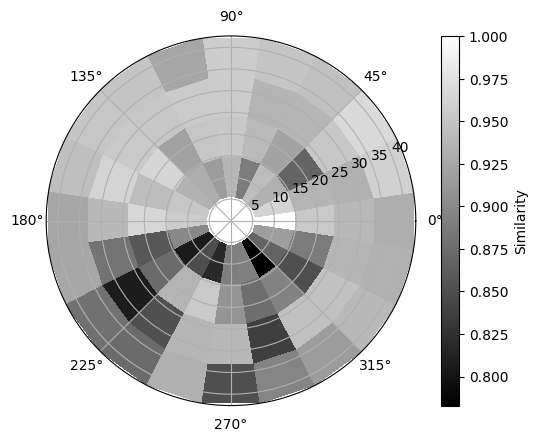

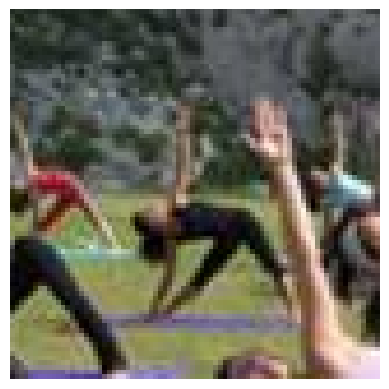

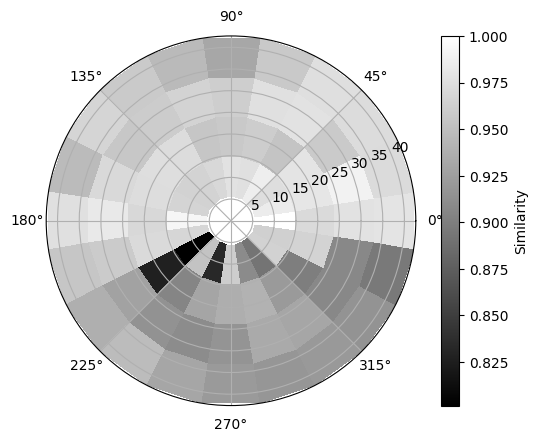

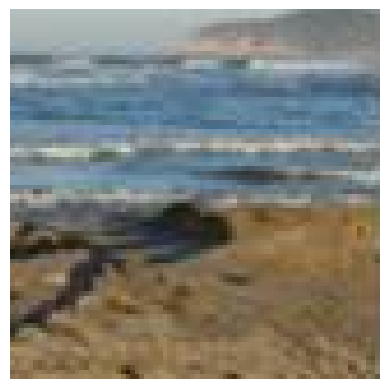

In [113]:
from utils import image_plot

loc1 = [12, 12]
loc2 = loc[loc1[0]][loc1[0]]

visualize_logpolar_feature(loc_self_sim_polar[0][loc1[0]][loc1[1]], radius)
s = np.transpose(images_np[0], [1, 2, 0])
s = s[loc1[0]*5:loc1[0]*5 + 80,loc1[1]*5:loc1[1]*5 + 80]
image_plot(s)


visualize_logpolar_feature(loc_self_sim_polar[4][loc2[0]][loc2[1]], radius)
s = np.transpose(images_np[4], [1, 2, 0])
s = s[loc2[0]*5:loc2[0]*5 + 80,loc2[1]*5:loc2[1]*5 + 80]
image_plot(s)